In [2]:
from Izh_net import *
import numpy as np
import matplotlib.pyplot as plt
from net_preparation import *

In [3]:
def run(T, sys, input):
    sys.set_init_conditions(
        v_noise=np.random.normal(size=sys.net.N)
    )
    V = np.zeros((len(T), N))
    F_flex = np.zeros(len(T))
    F_ext = np.zeros(len(T))
    Afferents = np.zeros((len(T), 6))
    Q = np.zeros(len(T))
    W = np.zeros(len(T))
    dt = T[1] - T[0]
    for i, t in enumerate(T):
        V[i] = sys.net.V_prev
        F_flex[i] = sys.F_flex
        F_ext[i] = sys.F_ext
        Afferents[i] = sys.Limb.output
        Q[i] = sys.q
        W[i] = sys.w
        sys.step(dt = dt, Iapp = input(t))
    return V, F_flex, F_ext, Afferents, Q, W

In [94]:
# Creating system
# application current matrix
Q_app = np.array([
            [0, 0],#I[0] -> 1st neuron
            [1, 0],
            [0, 1],#I[1] -> 3d neuron
            [0, 0]
        ])

# afferent matrix
Q_aff = 0.5*np.ones((4, 6))
# output matrix
P = np.array([
            [0, 1, 0, 0],
            [0, 0, 1, 0]
        ])
# neuron types
# Create params' array from neurons
a = 0.001
b = 0.3
c = -45
d = 2

N=4
A = a * np.ones(N) #+ 0.0001 * np.random.randn(N)  # Adding fixed noise to a
A[0] = 0.1; A[3] = 0.1
B = b * np.ones(N)
B[0] = 0.2; B[3] = 0.2
C = c * np.ones(N)
C[0] = -65; C[3] = -65
D = d * np.ones(N)
D[0] = 0.05; D[3] = 0.05

print(A, B, C, D)

net = Izhikevich_IO_Network(input_size = 2, output_size = 2, 
                                afferent_size = 6,
                                N=4, Q_app = Q_app,
                                Q_aff = Q_aff , P = P)

net.set_params(a=A, b=B, c=C, d=D) 
net.M = np.ones((N, N))

    
# Limb settings
flexor = SimpleAdaptedMuscle(w = 0.5, N=10)
extensor = SimpleAdaptedMuscle(w = 0.5, N=10)
Limb = OneDOFLimb(q0=np.pi/2, b=0.001, a1 = 0.4,
                      a2= 0.05, m=0.3, l=0.3)
AL = Afferented_Limb(
                Limb = Limb,
                Flexor = flexor,
                Extensor = extensor
            )

# Creating all system
sys = Net_Limb_connect(Network=net,
                           Limb = AL)
# Define the parameter sets for each Q
w1 =  0.1
q = 0
tau = 80
sys.net.set_weights(np.array([
                    [0, w1*q, 0, -w1],
                    [w1*q, 0, -w1, 0],
                    [0, -w1, 0, w1*q],
                    [-w1, 0, w1*q, 0]
                ])
                )
            
sys.net.set_synaptic_relax_constant(
                    np.array(
                        [
                            [1, tau, 1, tau],
                            [tau, 1, tau, 1],
                            [1, tau, 1, tau],
                            [tau, 1, tau, 1]
                        ]
                    )
                )
             
T_max = 20000
time_scale = 50
T = np.linspace(0, T_max, T_max*time_scale)
I = np.zeros(2)
I[0] = 0.1
I[1] = 0
input = lambda t: (I)

[0.1   0.001 0.001 0.1  ] [0.2 0.3 0.3 0.2] [-65. -45. -45. -65.] [0.05 2.   2.   0.05]


In [95]:
V, F_flex, F_ext, Afferents, Q, W = run(T, sys, input)

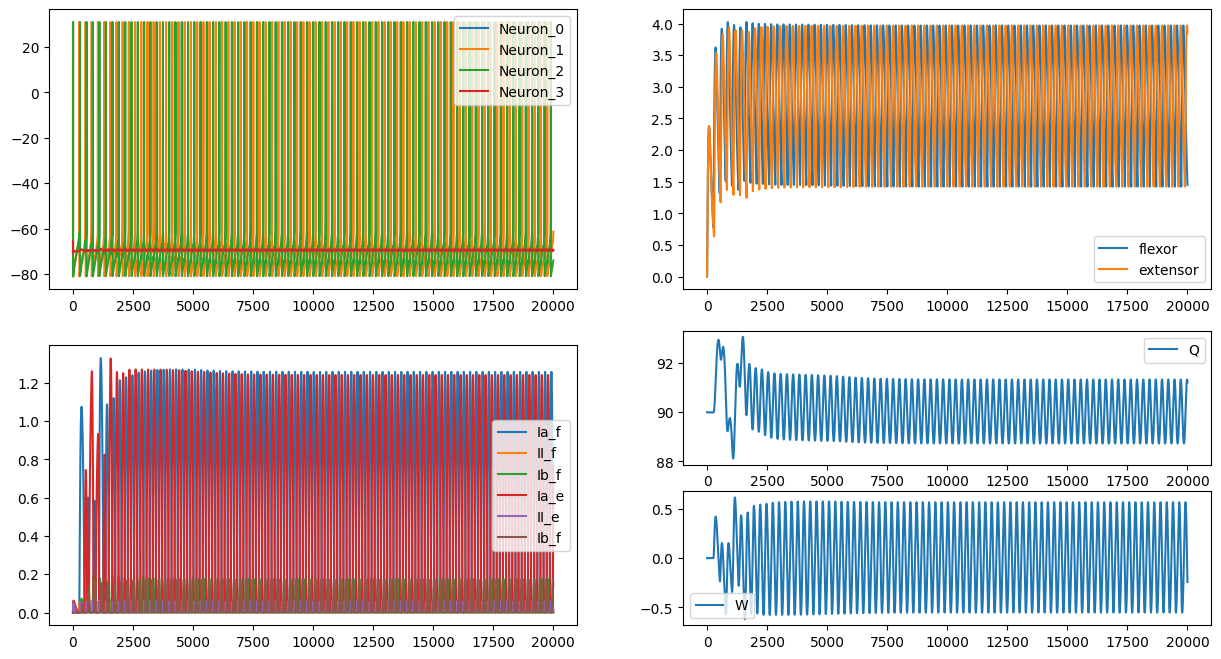

In [96]:
# running system
plt.figure(figsize=(15, 8))
plt.subplot(221)
     
for i in range(N):
    plt.plot(T, V[:, i], label=f"{sys.net.names[i]}")
plt.legend()

plt.subplot(222)
plt.plot(T, F_flex, label='flexor')
plt.plot(T, F_ext, label='extensor')
plt.legend()

plt.subplot(223)
aff_types = ['Ia_f', 'II_f', 'Ib_f', 'Ia_e', 'II_e', 'Ib_f' ]
for i in range(6):
    plt.plot(T, Afferents[:, i], label=aff_types[i])
plt.legend()

plt.subplot(426)
plt.plot(T, Q*180/np.pi, label="Q")
plt.legend()
plt.subplot(428)
plt.plot(T, W, label='W')
plt.legend()
plt.show()